In [1]:
import shapefile
from shapely.geometry import shape, Point, mapping
import numpy as np
import pandas as pd

base = "../../data/"
filename = "raw/2016_LGA_SHAPE/LGA_2016_AUST"

sf = shapefile.Reader(base+filename)

centroids = list(map(lambda x: shape(x.__geo_interface__).centroid, sf.shapes()[:130]))

df = pd.DataFrame(sf.records())
nswdf = df[df[4] =="New South Wales"]
# drop "No usual address" - not a useful LGA
nswdf = nswdf[nswdf[0] != "LGA19499"]
nswdf.columns = ["code", "codenum", "name", "unknown", "state", "unknown2"]
nswdf["clean_name"] = nswdf["name"].str.extract('([^\\(]*)', expand=False).str.strip()
nswdf['long'] = np.asarray([x.x for x in centroids])
nswdf['lat'] = np.asarray([x.y for x in centroids])
nswdf

,code,codenum,name,unknown,state,unknown2,clean_name,long,lat
0,LGA10050,10050,Albury (C),1,New South Wales,305.9459,Albury,146.970424,-36.026604
1,LGA10130,10130,Armidale Regional (A),1,New South Wales,8620.6990,Armidale Regional,151.829150,-30.336349
2,LGA10250,10250,Ballina (A),1,New South Wales,484.9389,Ballina,153.486147,-28.852885
3,LGA10300,10300,Balranald (A),1,New South Wales,21690.6753,Balranald,143.611623,-33.950350
4,LGA10470,10470,Bathurst Regional (A),1,New South Wales,3817.8646,Bathurst Regional,149.525634,-33.430139
5,LGA10550,10550,Bega Valley (A),1,New South Wales,6278.8811,Bega Valley,149.717569,-36.825941
6,LGA10600,10600,Bellingen (A),1,New South Wales,1600.4337,Bellingen,152.728589,-30.403803
7,LGA10650,10650,Berrigan (A),1,New South Wales,2065.7759,Berrigan,145.711213,-35.734325
8,LGA10750,10750,Blacktown (C),1,New South Wales,240.0487,Blacktown,150.864351,-33.741329
9,LGA10800,10800,Bland (A),1,New South Wales,8557.6535,Bland,146.961268,-33.894344


In [3]:
#average distance between nearest neighbours
dist = []
for i in centroids:
    alldist = []
    for j in centroids:
        if i != j:
            alldist.append(i.distance(j))
    dist.append(np.min(alldist))
    
np.mean(dist)

0.46813379855385656

In [2]:
target = pd.read_csv(base+"processed/cleaned_target.csv")

In [3]:
target= target[target['Type']== 'Rate per 100,000 population']
target

,Year,Type,LGA,Assault - domestic violence,Assault - non-domestic violence,Sexual Offences,Robbery,Break and enter dwelling,Break and enter non-dwelling,Motor vehicle theft,...,Possession use of cannabis,Prohibited weapons offences,Trespass,Offensive conduct,Offensive language,Liquor offences,Breach AVO,Breach bail conditions,Resist or hinder officer,Transport regulatory offences
130,2013,"Rate per 100,000 population",Albury,548.1193,782.4602,218.4534,21.8453,641.4585,468.6817,282.0034,...,162.8470,254.2003,208.5237,303.8488,129.0861,389.2442,256.1862,1036.6604,148.9455,19.8594
131,2013,"Rate per 100,000 population",Armidale Regional,663.4881,796.8526,266.7289,33.3411,916.8806,480.1120,140.0327,...,413.4298,150.0350,226.7196,273.3971,146.7009,416.7639,316.7406,283.3995,140.0327,20.0047
132,2013,"Rate per 100,000 population",Ballina,340.7608,454.3477,198.1729,12.0837,408.4296,217.5069,120.8372,...,210.2567,79.7525,82.1693,60.4186,36.2511,116.0037,222.3404,174.0055,55.5851,2.4167
133,2013,"Rate per 100,000 population",Balranald,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,2013,"Rate per 100,000 population",Bathurst Regional,477.9646,696.1126,178.9303,36.7665,799.0588,343.1541,198.5391,...,286.7788,191.1858,200.9902,78.4352,36.7665,134.8105,218.1479,387.2739,105.3973,7.3533
135,2013,"Rate per 100,000 population",Bayside,254.7872,263.3681,79.8685,59.4063,290.4310,84.4890,200.0013,...,250.8267,93.7300,56.7661,23.7625,30.3632,34.9837,110.8918,188.7801,37.6240,1267.9952
136,2013,"Rate per 100,000 population",Bega Valley,310.9676,490.3720,146.5136,8.9702,149.5036,194.3547,89.7022,...,307.9775,134.5533,125.5831,182.3945,131.5632,340.8683,182.3945,122.5930,89.7022,0.0000
137,2013,"Rate per 100,000 population",Bellingen,193.7684,348.7831,139.5133,15.5015,286.7772,341.0324,131.7625,...,248.0236,85.2581,85.2581,38.7537,54.2552,131.7625,224.7714,85.2581,77.5074,0.0000
138,2013,"Rate per 100,000 population",Berrigan,284.9003,249.2877,130.5793,0.0000,367.9962,308.6420,47.4834,...,356.1254,296.7711,249.2877,130.5793,83.0959,284.9003,178.0627,106.8376,71.2251,0.0000
139,2013,"Rate per 100,000 population",Blacktown,574.6330,543.5301,160.7494,112.7094,525.3611,122.8717,276.5383,...,206.0179,117.9445,94.5404,24.9439,33.2585,60.3580,222.6472,641.1500,58.2024,2022.3017


In [6]:
# impute with 1, 0 is bad for log
nswdf_target = pd.merge(nswdf, target, left_on='clean_name', right_on='LGA')

nswdf_target = nswdf_target.fillna(value=0.1)
# log it
start_col = nswdf_target.columns.get_loc('Assault - domestic violence')
for i in range(27):
    nswdf_target = nswdf_target.replace(0.0, 0.1)
    nswdf_target.iloc[:,start_col+i] = np.log(nswdf_target.iloc[:,start_col+i])
nswdf_target

,code,codenum,name,unknown,state,unknown2,clean_name,long,lat,Year,...,Possession use of cannabis,Prohibited weapons offences,Trespass,Offensive conduct,Offensive language,Liquor offences,Breach AVO,Breach bail conditions,Resist or hinder officer,Transport regulatory offences
0,LGA10050,10050,Albury (C),1,New South Wales,305.9459,Albury,146.970424,-36.026604,2013,...,5.092811,5.538123,5.340053,5.716530,4.860480,5.964207,5.545905,6.943760,5.003580,2.988677
1,LGA10050,10050,Albury (C),1,New South Wales,305.9459,Albury,146.970424,-36.026604,2014,...,5.663366,5.893289,5.278103,5.364281,4.800067,5.826225,5.871430,6.620968,5.161569,3.380984
2,LGA10050,10050,Albury (C),1,New South Wales,305.9459,Albury,146.970424,-36.026604,2015,...,5.894212,5.793002,5.195703,5.248070,4.723546,5.288076,5.833587,6.666990,5.069822,3.371154
3,LGA10050,10050,Albury (C),1,New South Wales,305.9459,Albury,146.970424,-36.026604,2016,...,6.039830,5.756704,5.116667,4.981492,4.177119,5.454780,5.892505,6.916060,5.105106,2.596672
4,LGA10050,10050,Albury (C),1,New South Wales,305.9459,Albury,146.970424,-36.026604,2017,...,5.471040,5.620572,5.255929,4.913438,3.828813,5.139395,5.908254,7.211789,4.825146,3.483972
5,LGA10130,10130,Armidale Regional (A),1,New South Wales,8620.6990,Armidale Regional,151.829150,-30.336349,2013,...,6.024488,5.010869,5.423714,5.610925,4.988396,6.032520,5.758083,5.646858,4.941876,2.995967
6,LGA10130,10130,Armidale Regional (A),1,New South Wales,8620.6990,Armidale Regional,151.829150,-30.336349,2014,...,6.170292,5.463159,5.825452,5.294823,4.755827,5.743774,5.390134,5.531212,5.112502,1.200477
7,LGA10130,10130,Armidale Regional (A),1,New South Wales,8620.6990,Armidale Regional,151.829150,-30.336349,2015,...,6.145525,5.500831,6.227203,5.167058,4.693273,5.500831,5.430872,5.685402,4.662502,1.196767
8,LGA10130,10130,Armidale Regional (A),1,New South Wales,8620.6990,Armidale Regional,151.829150,-30.336349,2016,...,6.471774,5.659568,6.210939,5.200993,3.832718,4.931329,5.182643,5.600379,4.329153,2.579952
9,LGA10130,10130,Armidale Regional (A),1,New South Wales,8620.6990,Armidale Regional,151.829150,-30.336349,2017,...,5.747536,5.747536,6.021973,5.125485,4.238182,5.144903,5.236711,5.336794,3.758608,2.579952


In [9]:
nswdf_target.mean()

unknown2                           5568.246322
long                                149.650631
lat                                 -32.976853
Year                               2015.000000
Assault - domestic violence           5.418209
Assault - non-domestic violence       5.455726
Sexual Offences                       4.707707
Robbery                               1.716770
Break and enter dwelling              5.513997
Break and enter non-dwelling          4.837067
Motor vehicle theft                   4.550906
Steal from motor vehicle              5.584616
Steal from retail store               4.536630
Steal from dwelling                   5.247717
Steal from person                     2.311182
Fraud                                 5.438072
Malicious damage to property          6.260452
Harassment threatening                5.498102
Receiving stolen goods                3.441228
Other theft                           5.389597
Arson                                 3.812201
Possession us

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.cross_validation import LeaveOneOut
import numpy as np

# 27 models for 27 crimes
models = []
for i in range(2):
    #crime index - index of first crime column
    start_col = nswdf_target.columns.get_loc('Assault - domestic violence')
    
    gp = GaussianProcessRegressor(normalize_y=True)
    
    gp.fit(nswdf_target.loc[:, ['lat','long']], nswdf_target.iloc[:,start_col+i])
    models.append(gp)

In [18]:
models[0].log_marginal_likelihood()

-572374125114.7739

In [85]:
nswdf_target.loc[:, ['lat','long', nswdf_target.columns[start_col+i]]].describe()

,lat,long,Assault - non-domestic violence
count,625.000000,625.000000,625.000000
mean,-32.976853,149.650631,5.455726
std,1.946970,2.473787,2.053850
min,-36.825941,141.479266,-2.302585
25%,-34.083345,148.065556,5.459039
50%,-33.697544,150.630295,5.943089
75%,-31.619027,151.202739,6.348186
max,-28.360000,153.486147,7.511192


(1, 2)

/Users/tdm/git/capstone/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  del sys.path[0]


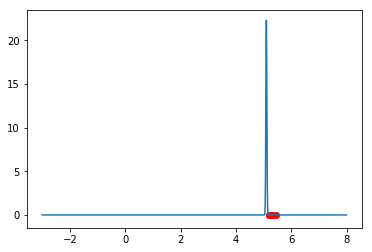

In [47]:
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

def plot_marginal(lga, crimetype):
    model = GaussianProcessRegressor(normalize_y=True)
    loo_row_indexer = nswdf_target['clean_name']!=lga
    model.fit(nswdf_target.loc[loo_row_indexer, ['lat','long']], nswdf_target.loc[loo_row_indexer,nswdf_target.columns[start_col+i]])
    lga_loc = np.asarray(nswdf_target.loc[nswdf_target['clean_name']==lga, ['lat', 'long']].iloc[0]).reshape([1,2])
    mu, sigma = model.predict(lga_loc, return_std=True)

    x = np.linspace(-3, 8, 1000)
    plt.plot(x,mlab.normpdf(x, mu, sigma))
    plt.scatter(x=nswdf_target.loc[nswdf_target['clean_name']==lga, crimetype], y=np.zeros(5), color='red')
    
plot_marginal('Willoughby', 'Assault - non-domestic violence')

In [40]:
nswdf_target.loc[:,nswdf_target.columns[start_col+i]].mean()

5.455725813427882

/Users/tdm/git/capstone/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  del sys.path[0]


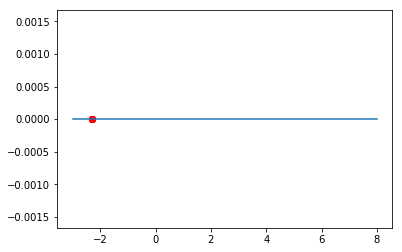

In [48]:
plot_marginal('Bogan', 'Assault - non-domestic violence')

/Users/tdm/git/capstone/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  del sys.path[0]


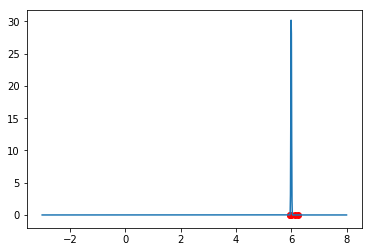

In [49]:
plot_marginal('Wollongong', 'Assault - non-domestic violence')

/Users/tdm/git/capstone/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  del sys.path[0]


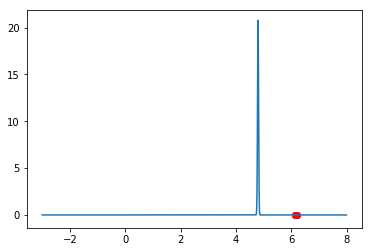

In [50]:
plot_marginal('Penrith', 'Assault - non-domestic violence')